In [1]:
#Imports
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get run duration (max Time) from each CSV
CSV_DIR = "../data/CSV"

durations = {}
for f in os.listdir(CSV_DIR):
    if not f.lower().endswith(".csv"):
        continue
    try:
        csv_df = pd.read_csv(os.path.join(CSV_DIR, f))
        durations[f] = csv_df["Time"].max()
    except Exception as e:
        print(f"Skipped {f}: {e}")

duration_df = pd.DataFrame({
    "file_name": list(durations.keys()),
    "run_duration": list(durations.values())
})
print(f"Parsed durations for {len(duration_df)} files")
print(f"Duration range: {duration_df['run_duration'].min():.2f}s - {duration_df['run_duration'].max():.2f}s")

Parsed durations for 445 files
Duration range: 0.10s - 50.00s


In [3]:
#Load features_updated and merge with durations
df = pd.read_csv("../data/features_updated.csv")
feature_cols = [c for c in df.columns if c != "file_name"]

df = pd.merge(df, duration_df, on="file_name", how="inner")
print(f"Matched samples: {len(df)} / {len(duration_df)}")
print(f"Features to test: {len(feature_cols)}")


Matched samples: 445 / 445
Features to test: 63


In [10]:
#Correlate each feature with run duration
results = []

for feat in feature_cols:
    #Convert to numeric: anything weird becomes NaN
    x = pd.to_numeric(df["run_duration"], errors="coerce")
    y = pd.to_numeric(df[feat], errors="coerce")

    #Keep only rows where both are present
    valid = pd.DataFrame({"x": x, "y": y}).dropna()
    if len(valid) < 5:
        continue

    #Skip if either variable is constant (correlation undefined)
    if valid["x"].nunique() < 2 or valid["y"].nunique() < 2:
        continue

    r, p = stats.pearsonr(valid["x"], valid["y"])
    results.append({
        "feature": feat,
        "pearson_r": r,
        "p_value": p,
        "abs_r": abs(r),
        "n_samples": len(valid)
    })

corr_df = pd.DataFrame(results).sort_values("abs_r", ascending=False)

#drop undefined correlations
corr_df = corr_df.dropna(subset=["pearson_r", "p_value"]).reset_index(drop=True)
#ADDING FDR Correction (from my STAT 550)
from statsmodels.stats.multitest import multipletests

rejected, p_adjusted, _, _ = multipletests(
    corr_df["p_value"],
    alpha=0.05,
    method="fdr_bh"
)
corr_df["p_adjusted"] = p_adjusted
corr_df["significant_fdr"] = rejected
#Show 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
display(corr_df)

#print how many features remained
print(f"Remaining features with defined correlation: {len(corr_df)}")

ModuleNotFoundError: No module named 'statsmodels'

In [8]:
# Flag features correlated with run duration using FDR-adjusted significance

sig = corr_df[corr_df["significant_fdr"]]
not_sig = corr_df[~corr_df["significant_fdr"]]

print(f"{'='*70}")
print(f"FEATURES CORRELATED WITH RUN DURATION (p < {alpha}) — consider removing")
print(f"{'='*70}")
for _, row in sig.iterrows():
    print(f"  ✗ {row['feature']:45s}  r={row['pearson_r']:+.3f}  p={row['p_value']:.4f}")
print(f"\nTotal: {len(sig)} features flagged")

print(f"\n{'='*70}")
print(f"FEATURES NOT CORRELATED WITH RUN DURATION (p >= {alpha}) — safe to keep")
print(f"{'='*70}")
for _, row in not_sig.iterrows():
    print(f"  ✓ {row['feature']:45s}  r={row['pearson_r']:+.3f}  p={row['p_value']:.4f}")
print(f"\nTotal: {len(not_sig)} features safe")

FEATURES CORRELATED WITH RUN DURATION (p < 0.05) — consider removing
  ✗ a0_rms_change_points                           r=+0.384  p=0.0000
  ✗ a1_rms_change_points                           r=+0.350  p=0.0000
  ✗ a1_spectral_flatness                           r=+0.318  p=0.0000
  ✗ a1_peaks_per_second                            r=-0.309  p=0.0000
  ✗ a0_peaks_per_second                            r=-0.298  p=0.0000
  ✗ a1_num_boilings                                r=-0.283  p=0.0000
  ✗ a0_mean_time_diff                              r=+0.271  p=0.0000
  ✗ a1_mean_time_diff                              r=+0.270  p=0.0000
  ✗ a1_median_time_diff                            r=+0.267  p=0.0000
  ✗ a0_num_boilings                                r=-0.266  p=0.0000
  ✗ a0_median_time_diff                            r=+0.266  p=0.0000
  ✗ a0_sum_peak_magnitude                          r=+0.253  p=0.0000
  ✗ a1_sum_peak_magnitude                          r=+0.243  p=0.0000
  ✗ a0_rms           

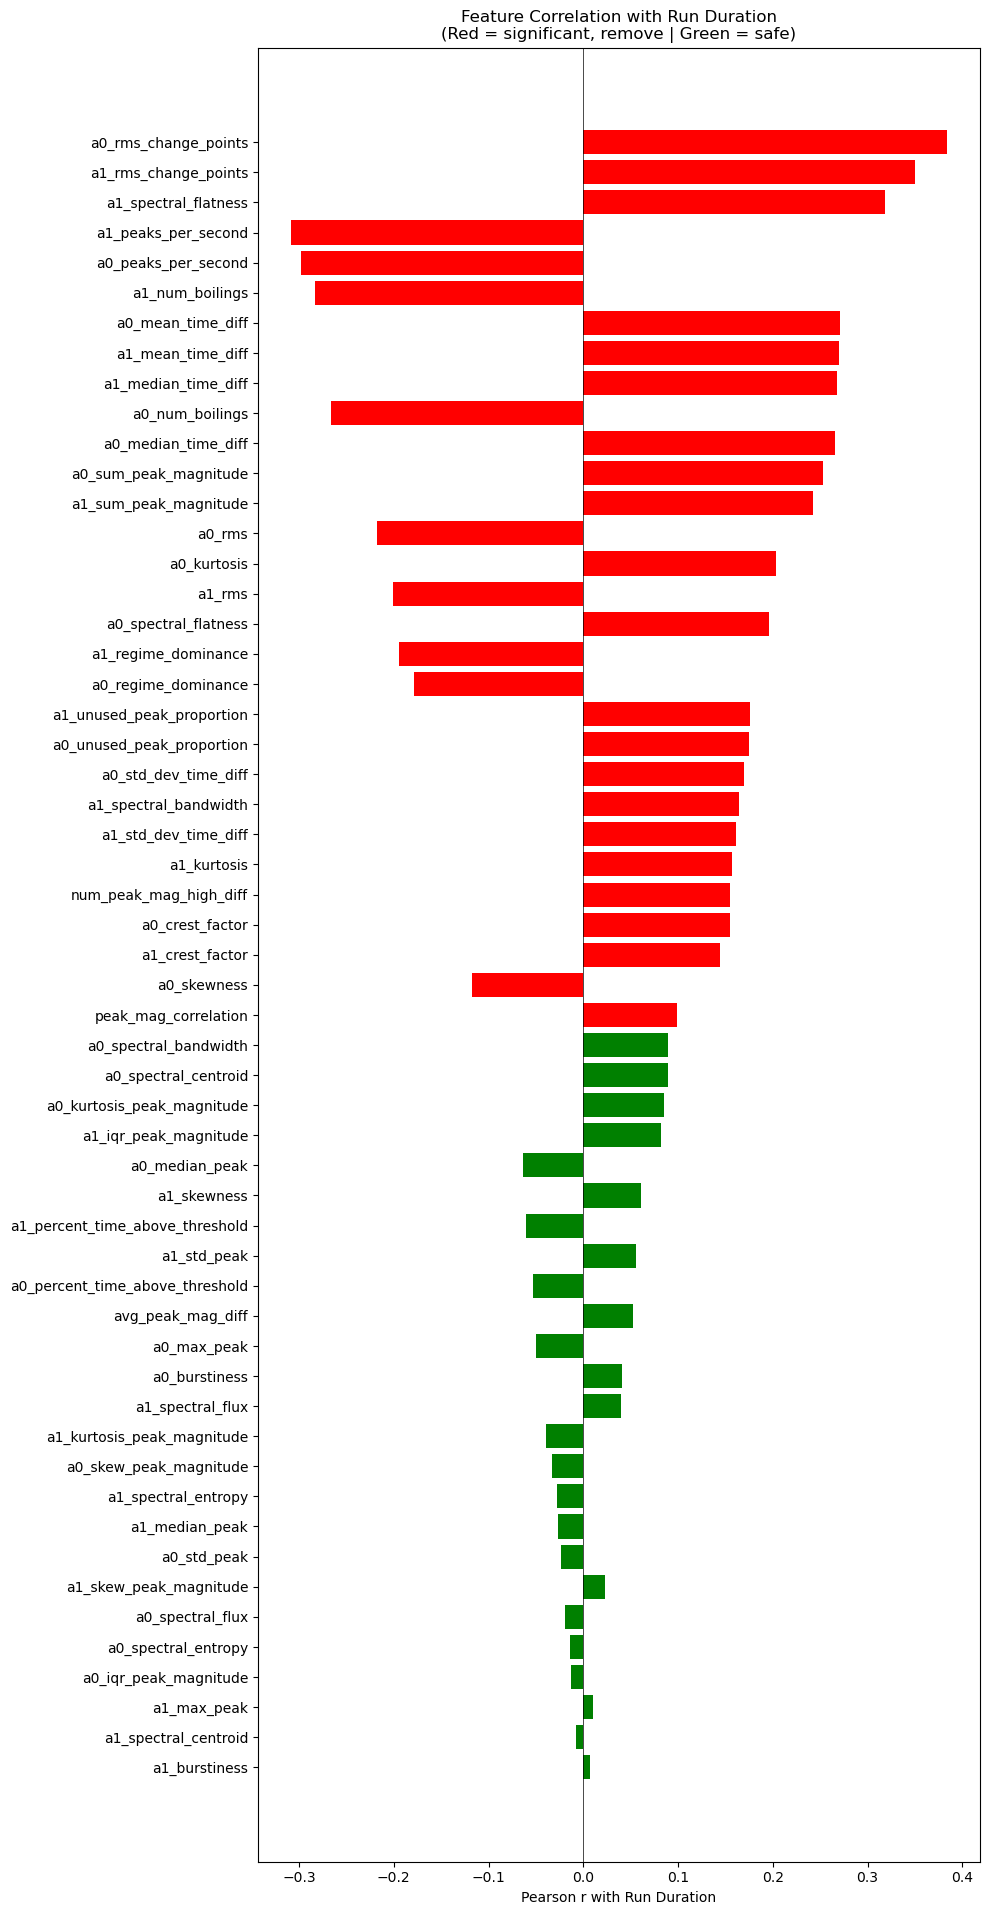

In [9]:
#Bar chart of correlations
corr_df_sorted = corr_df.sort_values("abs_r", ascending=True)

fig, ax = plt.subplots(figsize=(10, max(6, len(corr_df_sorted) * 0.35)))
colors = ["red" if p < alpha else "green" for p in corr_df_sorted["p_value"]]
ax.barh(corr_df_sorted["feature"], corr_df_sorted["pearson_r"], color=colors)
ax.axvline(x=0, color="black", linewidth=0.5)
ax.set_xlabel("Pearson r with Run Duration")
ax.set_title("Feature Correlation with Run Duration\n(Red = significant, remove | Green = safe)")
plt.tight_layout()
plt.savefig("time_duration_correlation.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
#Save results
# corr_df["flagged_for_removal"] = corr_df["p_value"] < alpha
# corr_df.to_csv("feature_duration_correlation.csv", index=False)
# print("\nSaved: feature_duration_correlation.csv")

# # List of safe feature names (for easy copy into your clustering code)
# safe_features = not_sig["feature"].tolist()
# print(f"\nSafe features list ({len(safe_features)}):")
# print(safe_features)